
## **<font color='blue'>0.0 Learning Objectives</font>**

The focus of this assignment is to perform Sentiment Analysis on the provided Twitter data regarding the Canadian Elections.

Two datasets were considered for this assignement: **<font color='green'> 'Canadian_elections_2021.csv' and 'sentiment_analysis.csv'</font>** 

The learnings expected are:
1. Data Cleaning of the web-scrapped data
2. Data Exploration for indepth understanding
3. Exploration of different models
4. Text Classification



## **<font color='blue'>0.1 Setup</font>**


*   Install the required libraries using `!pip install <library_name> `
*   Import the required libraries



In [1]:
#Importing required libraries
import pandas as pd
import numpy as np
import re
import string
import html

import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

import io

#Installing required libraries
#!pip install <library_name>

#NLTK Library
try:
  import nltk
  from nltk.stem import WordNetLemmatizer
  from nltk.corpus import stopwords
except:
  !pip install nltk
  import nltk
  from nltk.stem import WordNetLemmatizer
  from nltk.corpus import stopwords

#sklearn Library
try:
  from sklearn.linear_model import LogisticRegression
  from sklearn.neighbors import KNeighborsClassifier
  from sklearn.naive_bayes import MultinomialNB
  from sklearn.svm import SVC
  from sklearn.tree import DecisionTreeClassifier
  from sklearn.ensemble import RandomForestClassifier


  from sklearn.model_selection import train_test_split
  from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
  from sklearn.metrics import confusion_matrix, classification_report
  from sklearn import metrics
  from sklearn.model_selection import GridSearchCV
  from sklearn.model_selection import StratifiedKFold

except:
  !pip install sklearn

  from sklearn.linear_model import LogisticRegression
  from sklearn.neighbors import KNeighborsClassifier
  from sklearn.naive_bayes import MultinomialNB
  from sklearn.svm import SVC
  from sklearn.tree import DecisionTreeClassifier
  from sklearn.ensemble import RandomForestClassifier


  from sklearn.model_selection import train_test_split
  from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
  from sklearn.metrics import confusion_matrix, classification_report
  from sklearn import metrics
  from sklearn.model_selection import GridSearchCV
  from sklearn.model_selection import StratifiedKFold

try:
  from xgboost import XGBClassifier
except:
  !pip install xgboost
  from xgboost import XGBClassifier


try:
  from venn import venn
except:
  !pip install venn
  from venn import venn

from tqdm import tqdm

from google.colab import files


  Created wheel for venn: filename=venn-0.1.3-py3-none-any.whl size=19714 sha256=44ee0c532b564eb76e131bb017da3c96c6fdd9e7413b796bb0bc20b826359375
  Stored in directory: /root/.cache/pip/wheels/85/8c/61/85a84e4c69c79c6475b9689755fc4ee4dae0bdc32b101011cb
Successfully built venn


## **<font color='blue'>0.2 Uploading Dataset</font>**
For uploading the datasets, 'files.upload()' option is used. 

Select the two files to be analyzed
1. 'sentiment_analysis.csv'
2. 'Canadian_elections_2021.csv'

These uploaded files will be later used to load into the pandas dataframe.

In [2]:
uploaded = files.upload()

Saving Canadian_elections_2021.csv to Canadian_elections_2021.csv
Saving sentiment_analysis.csv to sentiment_analysis.csv


## **<font color='blue'>0.3 Download Stopwords</font>**

Dowloading the stopwords from the nltk library for later use.

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# **<font color=#800000>Task 1: Data Cleaning</font>** 


## **<font color='orange'>1.1 Loading Data</font>**
The below cell loads the data provided into the .csv files. 

The output cell prints the shape of the datasets along-with the column names.



In [4]:
#Load the provided dataset into a dataframe.
gen_data = pd.read_csv(io.BytesIO(uploaded['sentiment_analysis.csv']), low_memory=False)
can_data = pd.read_csv(io.BytesIO(uploaded['Canadian_elections_2021.csv']), low_memory=False)

#Print the shape of the general sentiment dataset
print("The shape of the general sentiment dataset is: {}".format(gen_data.shape))
print("The columns for the general sentiment dataset are: {}".format(gen_data.columns))

print("\nThe shape of the canadian election dataset is: {}".format(can_data.shape))
print("The columns for the canadian election dataset are: {}".format(can_data.columns))

The shape of the general sentiment dataset is: (550391, 3)
The columns for the general sentiment dataset are: Index(['ID', 'text', 'label'], dtype='object')

The shape of the canadian election dataset is: (1002, 3)
The columns for the canadian election dataset are: Index(['text', 'sentiment', 'negative_reason'], dtype='object')


The sample output of both the files is:

In [5]:
#Sample Output
print("The sample generic dataset examples:")
display(gen_data.head(5))

print("\nThe sample canadian election dataset examples:")
display(can_data.head(5))

#Copying the original dataframes for later use
gen_use = gen_data.copy()
can_use = can_data.copy()

The sample generic dataset examples:


,ID,text,label
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1



The sample canadian election dataset examples:


,text,sentiment,negative_reason
0,The Canadian election is a power grab by PM Tr...,negative,calling election early
1,I do hope Trudeau loses the Canadian election ...,negative,covid
2,"Dear Canadians, This election is a test of how...",positive,NaN
3,Canadian friends: Never forget that Trudeau ha...,negative,calling election early
4,Sorry @theJagmeetSingh I have voted #NDP all m...,positive,NaN


## **<font color='orange'>1.2 Cleaning Dataset</font>**

The most important step for this assignment is to clean the data. The data scrapped from the websites will contain a lot of noise. To clean the cluttered data, several steps were followed keeping in mind the assignment request.

A function was written to clean the tweets with sequential steps:
1. The html tags and attributes were eliminated using the regex library function called 'sub'. The data present in the tags (including multiple occurences) was replaced with '' (null) character. 

2. The html character codes were converted.

3. All the urls present in the data were substituted with ''.

4. The data was converted to lower-case

5. Although, the removal of punctuations such as '-', '!' were not mentioned in the assignment request, those were eliminated. Initially, this was neglected but after visualizing the cleaned tweets, it was realized that the punctuations might be considered as a unique word which can iduce higher features in the vectorized dataset and slow the performance of the models later on. 

6. It can be observed that an additional condition is used inside the function while removing the punctuations. This was done to provide an option in case the punctuations were required. For this assignment, as it was required to assign the tweets to a particular party in the following tasks, '#' and '@' were excluded while removing the punctuations. In addition once the tweets were assigned, these were later removed before the model implementation.

7. The inbuilt english stopwords set from the nltk library was used for the removal of such words from the tweet. In addition to those words several other words can also be added based on our requirement. For this study, only the word 'rt' which repeats for all tweets was added. 











In [6]:
def clean_tweet(data, stops, rem = False):

  #remove html tags and attributes
  data = re.sub('(<[^>]*>)','',data)

  #Convert character codes to string
  data = html.unescape(data)

  #remove urls
  data = re.sub("(\w+:\/\/\S+)|(http[^\s]+)|(www.[^\s]+)",'',data, flags=re.MULTILINE)

  #lower case
  data = data.lower()

  if rem==False:
    #remove punctuations apart from the @ and # which can be useful later
    data = data.translate(str.maketrans('', '', re.sub('#|@','',(string.punctuation))))
  else:
    data = re.sub(r'\@\w+|\#\w+','', data)
    data = data.translate(str.maketrans('', '', (string.punctuation)))

  #stopwords
  data = [word for word in str(data).split() if word not in stops]

  #Join all the words using ' ' before returning the tweet
  return " ".join(data)


Call the function for data cleaning.

In [7]:
#Using the stopwords
stops = stopwords.words('english')

#Add other required stopwords
stops.append('rt')

#Processing sentiment analysis file
gen_use['text'] = gen_data['text'].apply(lambda x: clean_tweet(x, stops))

#Processing canadian election fils
can_use['text'] = can_data['text'].apply(lambda x: clean_tweet(x, stops))


Visualize the processed tweets

In [8]:
print(can_use['text'][101])
print(gen_use['text'][101])

@cnnpr @jaketapper @cnn choose cnn media canada anything interesting election campaign especially ive voted however cnn seems running endless afghanistan sob story war time come home usa cnn try little faith people
@sheilascott moray wheelers project georgia raffle tickets lots lovely prizes @geegeemansfield #fundraisingnextolympians


# **<font color=#800000>Task 2: Exploratory Data Analysis</font>** 


## **<font color='orange'>2.1 Design a Procedure for Assigning Tweets to a Party</font>**

What can be used to identify a party's reference in the tweets?
1. Hashtags can be explored and cross-referenced with a particular party's related hashtags. 
2. Twitter handles starting with '@' can be used to identify the user and link their relation to a party.
3. Key words can be identified from the tweets and used to analyze if a party is referred in that particular tweet.

Before proceeding to the assigning the tweets to a party, the wordclouds of differnt handles and hashtags were visulaized to understand their occurence in the dataset. This visualization might provide insights of some relevant keywords to use for a particular party. 

Using the above ideas, the count of such words was calculated for each specified party and stored in the dataframe. It can be understood that for a particulat tweet there can be references to multiple parties. In order to develop an indepth understanding, a venn diagram was plotted for all four parties to visualize the overlap. It will be discussed in detail later.

Now, How should one specific party be selected for such a scenario?

In this assignment, the party which had the maximum count for a particular tweet was selected as the assigned party. 

The following cells implement the above presented idea and discuss the findings in detail.


**<font color='orange'>Analyzing Hashtags and Handles</font>**

The below cell defnies function for extracting handles and hashtags. These are then added to a new column respectively in the dataframe. 

In [9]:
#function to find hashtags
def find_hash(data):
  data = re.findall('#\w+', data)
  return [re.sub('#','',x) for x in data]

#function to find handles
def find_handles(data):
  data = re.findall('@\w+', data)
  return [re.sub('@','',x) for x in data]


can_use['hashtags'] = can_use['text'].apply(lambda x: find_hash(x))
can_use['handles'] = can_use['text'].apply(lambda x: find_handles(x))


Having gathered the handles and hashtags separately in different columns, a visualization is presented below using the wordclouds. 

These wordclouds can be used to define the keywords for the assignment of the tweet to a party.

We can observe that hashtags like 'voteppc2021', 'ppc', 'purplereign', 'conservative' etc. provide a good direction for the selection of different set of words during tweet assignment.

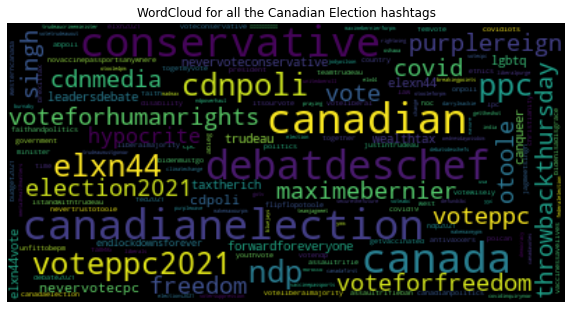

In [10]:
#Hashtags are currently stored in list format, these are exploded and joined as text before using wordcloud feature.
all_hash = can_use['hashtags'].explode().unique()
all_hash_drop = ' '.join(np.delete(all_hash, 0))

#Applying wordcloud
wordcloud = WordCloud(random_state=21, max_font_size=30).generate(all_hash_drop)

#Plotting the wordcloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('WordCloud for all the Canadian Election hashtags')
plt.show()

A similar idea can be followed using all the handles that are extracted from the tweets. Some of the handles that are most frequent are: 'thejagmeetsingh', 'erinotootle', 'codyotootle', 'cafreeland', 'maxinebernier' etc. These handles can be referenced with their affliation to a party.

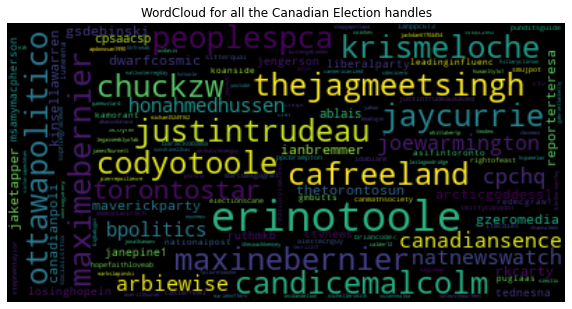

In [11]:
#Handles too are currently stored in the list format, these are exploded and joined for its input to wordcloud feature.
all_hand = can_use['handles'].explode().unique()

all_hand_drop = ' '.join(np.delete(all_hand, 0))

wordcloud = WordCloud(random_state=21, max_font_size=30).generate(all_hand_drop)

#Plotting Wordcloud for handles
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('WordCloud for all the Canadian Election handles')
plt.show()

## **<font color='orange'>2.2 Party Affiliation of a Tweet</font>**
 
The above analysis was used as a starting point to identify keywords relevant to a particular party. A list for each is prepared using those. Only few keywords were listed in this study for tweet assignment. However, an indepth research can be performed going through the politicians' profile on twitter, the party websites and the key hashtags used during the election campaign such as #fightingforyou, #forwardforeveryone etc. to develop an extensive and an accurate classification. 

In [12]:
#List of words that identify LPC
LPC = ['liberal', 'liberalparty', 'pm', 'government', 'lpc', 'justin', 'trudeau', 'justintrudeau', 'jt', 'cafreeland', 'forwardforeveryone']

#List of words that identify CPC
CPC = ['cpc_hq', 'conservative', 'conservativeparty', 'cpc', 'erin', 'otoole', 'erinotoole', 'codyotoole', 'kenney', 'jkenney']

#List of words that identify NDP
NDP = ['ndp', 'newdemocraticparty', 'newdemocratic', 'jagmeet', 'singh', 'thejagmeetsingh', 'jagmeetsingh', 'fightingforyou']

#List of words that identify PPC
PPC = ['ppc', 'peoplespartyofcanada', 'peoplesparty', 'maxime', 'bernier', 'maximebernier', 'peoplespca', 'purple']

The below function is used to identify a party which was referred in a particular tweet. Also, the '@' and '#' punctuations were eliminated before proceeding to assign the tweets as their part in the assignment is supposed to be completed.


In [14]:
#Function to identify the parties being refered in a tweet
def define_party(data):
  #The initial count of each party is 0
  #If a substring relevant to the party belongs to the above list, than the count for that party is increased

  lpc = 0
  for i in LPC:
    for word in str(data).split():
      if i in word:
        lpc+=1
  
  cpc = 0
  for i in CPC:
    for word in str(data).split():
      if i in word:
        cpc+=1
  
  ndp = 0
  for i in NDP:
    for word in str(data).split():
      if i in word:
        ndp+=1
  
  ppc = 0
  for i in PPC:
    for word in str(data).split():
      if i in word:
        ppc+=1
  
  #returns the list of the counts for each party for that particular tweet
  return [lpc, cpc, ndp, ppc]

#Function call
lp = can_use['text'].apply(lambda x: define_party(re.sub('@|#','',x)))

Now the returned list is stored in the dataframe.

In [15]:
#Defining separate lists for its use in Venn Diagram
lpc_set = []
cpc_set = []
ndp_set = []
ppc_set = []

#Looping over the length of lp - the list returned from the above function 
for i in range(len(lp)):
  #Storing the count in the specific column in the dataframe
  can_use.loc[i,'LPC'] = lp[i][0]

  #Appending the value to the list as well for venn diagram
  if lp[i][0]>0:
    lpc_set.append(i)

  #Repeating the steps for all parties
  can_use.loc[i,'CPC'] = lp[i][1]
  if lp[i][1]>0:
    cpc_set.append(i)

  can_use.loc[i,'NDP'] = lp[i][2]
  if lp[i][2]>0:
    ndp_set.append(i)

  can_use.loc[i,'PPC'] = lp[i][3]
  if lp[i][3]>0:
    ppc_set.append(i)

  #if no assignment is there, adding that tweet to 'Other'
  if lp[i][0]==0 and lp[i][1]==0 and lp[i][2]==0 and lp[i][3]==0:
    can_use.loc[i,'Other'] = 1
  else:
    can_use.loc[i,'Other'] = 0



**<font color='orange'>Distribution of Political Affiliation of a Tweet (Shared Tweets as well)</font>**

In this distribution plot, no maximum count was used. All the respective count values were considered. Hence, it can be seen that the total datapoitns are more than the original length. This is because some of the tweets were shared. Multiple parties are being referred to in several tweets. 

With this absolute counts, it can be seen that the 'LPC' party has the highest representation followed by 'CPC' - the two most popular parties in the election. Several tweets were marked as Other meaning that they either belonged to parties with marginal popularity or were neutral. The other two parties: 'NDP' and 'PPC' also had considerable share in the dataset. 

Having understood the distribution, the next cell presents the VENN DIAGRAM to observe the overlap among parties.






The distribution of tweets with respect to the party is: 
 Party  Count
   LPC    542
   CPC    398
   NDP     83
   PPC    112
 Other    206



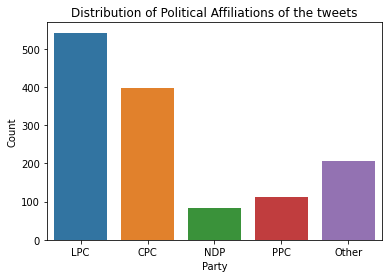

In [16]:
len_empty = len(can_use[(can_use.LPC==0)&(can_use.CPC==0)&(can_use.NDP==0)&(can_use.PPC==0)])
plot_hist = pd.DataFrame(columns=['Party','Count'])
plot_hist['Count'] = [len(lpc_set), len(cpc_set), len(ndp_set), len(ppc_set), len_empty]
plot_hist['Party'] = ['LPC','CPC','NDP','PPC', 'Other']

print("The distribution of tweets with respect to the party is: \n{}\n".format(plot_hist.to_string(index=False)))
ax = sns.barplot(data=plot_hist, x='Party', y='Count');
plt.title('Distribution of Political Affiliations of the tweets');


From the below diagram, it can be seen that the LPC and CPC had the most shared tweets (approximately 144). About 295 tweets only discussed about the 'LPC' party whereas 169 tweets were focused on the 'CPC' party. Several tweets also idenpendently referred to 'PPC' (39 tweets) and 'NDP' (19 tweets). 

This information can be used to understand how the distributions change when we consider the maximum count of tweets while assigning one party to each tweet. 

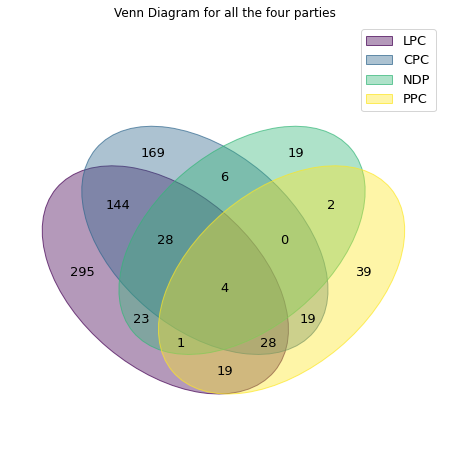

In [17]:
#Venn Diagram Plotting

#Creating a dictionary and inputting in the function venn.
venn_dict = {'LPC':set(lpc_set), 'CPC':set(cpc_set), 'NDP':set(ndp_set), 'PPC':set(ppc_set)}
venn(venn_dict);

#Plot
plt.title('Venn Diagram for all the four parties');
plt.show();


**<font color='orange'>Distribution of Political Affiliation of a Tweet to one particular party</font>**

The tasks that will be implemented later requires the assignment of one party to a particular tweet. In order to do so, the shared tweets dataset is used and the party that has the maximum count is assigned as the 'Party' for that particular tweet. 

The below cell presents the distribution for such a scenario. It can be seen that the count for all the parties are reduced when compared to the counts observed in the previous distribution where shared data was considered. This highlights that most of the tweets are being shared among the parties.

The counts for 'LPC' and 'CPC' party reduced the most. This mean that they are represented in a high number of shared tweets.  

The distribution of tweets with respect to the unique party is: 



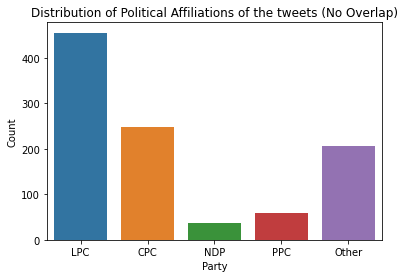

In [18]:
#Store party name with maximum count
can_use['Max'] = can_use.loc[:,['LPC','CPC','NDP','PPC','Other']].idxmax(axis=1)

bar_x = can_use['Max'].value_counts().index
bar_y = can_use['Max'].value_counts().values
bar_data = pd.DataFrame()
bar_data['Party'] = bar_x
bar_data['Count'] = bar_y

print("The distribution of tweets with respect to the unique party is: \n")
ax = sns.barplot(data=bar_data, x='Party',y='Count', order=['LPC','CPC','NDP','PPC','Other'] );
plt.title('Distribution of Political Affiliations of the tweets (No Overlap)');


## **<font color='orange'>2.3 Canadian Election Data Visualization</font>**

### **<font color='orange'>Canadian Dataset</font>**
 

One of the goals of this assignment is to identify the sentiment of the tweet from the canadian election dataset. There are two kinds of sentiments: 'negative' and 'positive'. 

Wordcloud is employed to understand what kind of words are present in the negative and positive tweets. The below code separates the negative and positive tweet and then presents two plots one for each sentiment. 

Discussions:
1. From the words present in the positive sentiment wordcloud plot, we see that there is a combination of both the positive and negative words.

2. The negative wordcloud is more inclined towards negative words. Some of the words which can be highlighted from this plot are 'horrible', 'guns' and 'suffering'. Interestingly, the word 'Trudeau' also appeared in the negative sentiment plot hinting a possible sentiment of 'LPC' party towards negative sentiment. 

3. There are a few generic and common words which could have been removed as a stopword such as 'Canadian', 'Election' and 'Canada'. 

 

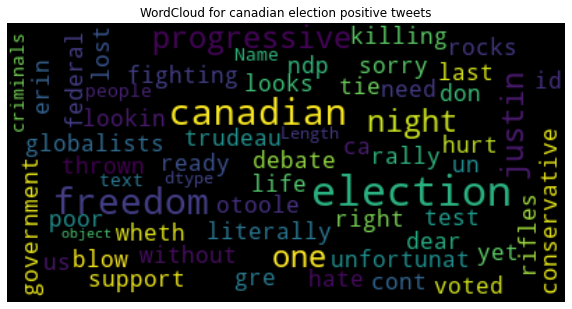

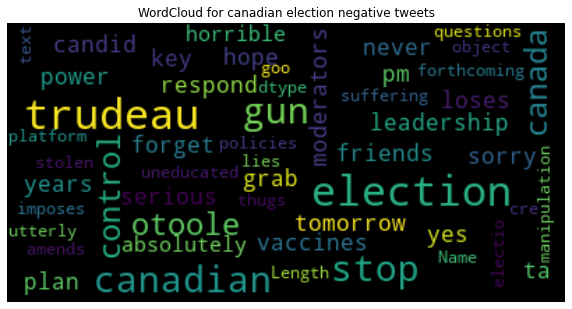

In [19]:
#Processing canadian election fils
can_use_r = can_use.copy()
can_use_r['text'] = can_data['text'].apply(lambda x: clean_tweet(x, stops, True))

#Select tweets with positive sentiment
can_use_posi = can_use_r[(can_use_r.sentiment=='positive')]
wordcloudp = WordCloud(random_state=21, max_font_size=30).generate(str(can_use_posi['text']))

#Plot wordcloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloudp, interpolation="bilinear")
plt.axis('off')
plt.title('WordCloud for canadian election positive tweets')
plt.show()

print("\n")

#Select tweets with negative sentiment
can_use_neg = can_use_r[(can_use_r.sentiment=='negative')]
wordcloudn = WordCloud(random_state=21, max_font_size=30).generate(str(can_use_neg['text']))

#Plot wordcloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloudn, interpolation="bilinear")
plt.axis('off')
plt.title('WordCloud for canadian election negative tweets')
plt.show()


The below cell presents the distribution of negative and positive tweets. It can be seen that positive tweets have a higher representation.

Among the negative tweets, the reason was also provided. The following plot presents the distribution of the negative reason. While most were termed as 'Others', a large number of negative tweets were termed negative beacuse of early elections.

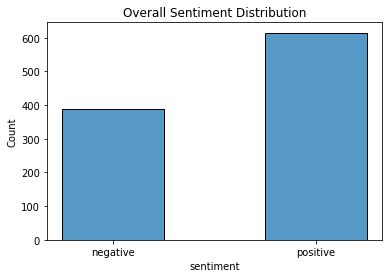

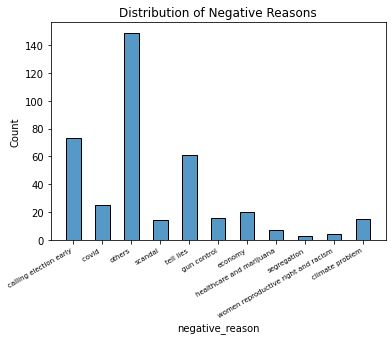

In [20]:
sns.histplot(data=can_use_r, x='sentiment',shrink=0.5);
plt.title('Overall Sentiment Distribution')
plt.show()

ax = sns.histplot(data=can_use_r, x='negative_reason', shrink=0.5)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right', fontsize='x-small')
plt.title('Distribution of Negative Reasons');
plt.show()

## **<font color='orange'>2.4 Generic Sentiment Dataset</font>**

A similar approach is followed for the generic tweets. This dataset is going to be used as the training set. The positive and negative cloud is presented below. We clearly see that higher order of negative words are found in the negative plot. 
 

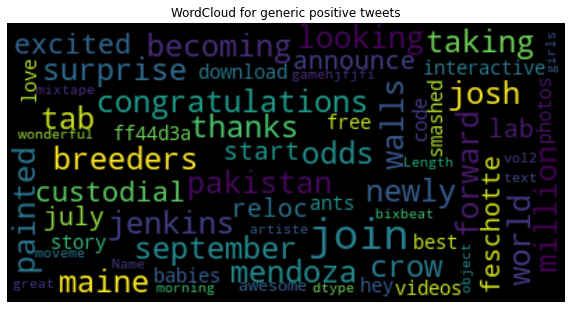

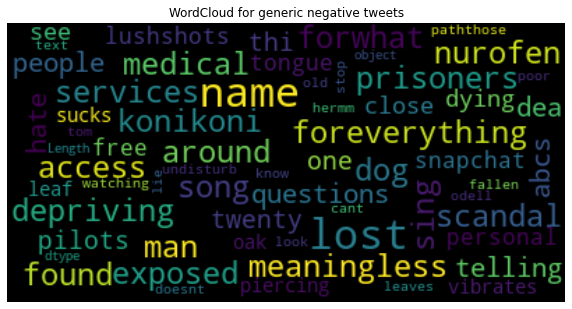

In [21]:
gen_use_r = gen_use.copy()
gen_use_r['text'] = gen_data['text'].apply(lambda x: clean_tweet(x, stops, True))


gen_use_posi = gen_use_r[(gen_use_r.label==1)]
wordcloud = WordCloud(random_state=21, max_font_size=30).generate(str(gen_use_posi['text']))

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('WordCloud for generic positive tweets')
plt.show()

gen_use_neg = gen_use_r[(gen_use_r.label==0)]
wordcloud = WordCloud(random_state=21, max_font_size=30).generate(str(gen_use_neg['text']))

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('WordCloud for generic negative tweets')
plt.show()

For the generic dataset as well the positive tweets have a higher representation. 

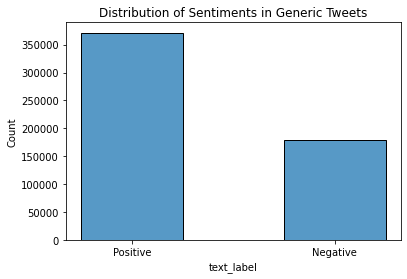

In [22]:
gen_use['text_label'] = gen_use['label'].apply(lambda x: 'Positive' if x == 1 else 'Negative')
ax = sns.histplot(data=gen_use, x='text_label', shrink=0.5)
plt.title('Distribution of Sentiments in Generic Tweets');
plt.show()

# **<font color=#800000>Task 3: Model Preparation</font>** 

1. Splitting the generic tweets into test and train dataset. 70% of the data is used as training set and the remaining data is considered as a test dataset.

2. The original text is than vectorized using two techniques as requested in the assignement: Bag-of-words, TF-IDF Vectorizer.

3. The vectorizer is fitted using only the training data. The fitted vectorizer is later used to find the vectorized output for the other sets using the tranform option.

1. Splitting the datasets (70%, 30%)

In [23]:
X = gen_use_r
y = gen_use_r['label']

#Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=100)

2. Vectorizing the dataset using CountVectorizer(). The number of features extracted are 128976.

The train data is used to fit the vectorizer and then the complete dataset is transformed based on this fitted vectorizer.

In [24]:
#Defining the Vectorizer
vectorizer_1 = CountVectorizer()
vectorizer_1.fit(X_train['text'].values)

#Transforming Data
X_train_bag = vectorizer_1.transform(X_train['text'].values)
X_test_bag = vectorizer_1.transform(X_test['text'].values)

print("Shape after count vectorizations")
print("Train Set X, y: {},{}".format(X_train_bag.shape, y_train.shape))
print("Test Set X, y: {}, {}".format(X_test_bag.shape, y_test.shape))

Shape after count vectorizations
Train Set X, y: (385273, 128976),(385273,)
Test Set X, y: (165118, 128976), (165118,)


3. Vectorizing the dataset using TfidfVectorizer(). The number of extracted features in this case are 128976.

In [25]:
#Defining the TFDIF Vectorizer
vectorizer_2 = TfidfVectorizer()
vectorizer_2.fit(X_train['text'].values)

#Tranform the test and validation sets
X_train_tf = vectorizer_2.transform(X_train['text'].values)
X_test_tf = vectorizer_2.transform(X_test['text'].values)

print("Shape after tfdif vectorizations")
print("Train Set X, y: {},{}".format(X_train_tf.shape, y_train.shape))
print("Test Set X, y: {}, {}".format(X_test_tf.shape, y_test.shape))

Shape after tfdif vectorizations
Train Set X, y: (385273, 128976),(385273,)
Test Set X, y: (165118, 128976), (165118,)


# **<font color=#800000>Task 4: Model Implementation and Tuning</font>** 





## **<font color='orange'>4.a Classifier Models</font>**

This section focuses on using the prepared data as the input to the 7 different models with different classification algorithms: logistic regression, k-NN, Naive Bayes, SVM, decision trees, Random Forest and XGBoost. These models are run separately twice for two different sets of inputs: for the features extracted with bag of words and with the features extracted with Tfidf.

The below cell implements a generalized function for each iteration of models runs. 

In [26]:
#function to implement model training
def model_implement(model, X, y, Xtest, ytest, check=True):
  
  #split the training dataset into train and validation sets (70%, 30%)
  X_tr, X_cv, y_tr, y_cv = train_test_split(X, y, test_size=0.30, stratify=y, random_state=120)

  #Model Fit
  model.fit(X_tr,y_tr)

  #Train Predictions
  y_pred_tr = model.predict(X_tr)

  #Tesy Predictions
  y_pred_cv = model.predict(X_cv)

  #check this for the case when XGBClassifier is used.
  if check==False:
    y1 = [round(value) for value in y_pred_tr]
    y2 = [round(value) for value in y_pred_cv]
    y_pred_tr = y1
    y_pred_cv = y2
  
  #Calculate Accuracies
  acc_tr = metrics.accuracy_score(y_tr, y_pred_tr)
  acc_cv = metrics.accuracy_score(y_cv, y_pred_cv)

  #Test Accuracies
  y_preds = model.predict(X_test_bag)
  acc_test = metrics.accuracy_score(y_test, y_preds)

  #Print Accuracies for comparison
  print("The accuracy score for the Train set is: {}".format(acc_tr))
  print("The accuracy score for the Validation set is: {}".format(acc_cv))
  print("The accuracy score for the Test set is: {}".format(acc_test))

  pass



### **<font color='orange'>MODEL 1: Logistic Regression Classifier</font>**


In [37]:
model1 = LogisticRegression(max_iter=10000)

print("\nResults when Count Vectorizer input is selected:\n")
model_implement(model1, X_train_bag, y_train, X_test_bag, y_test)

print("\nResults when Tfidf Vectorizer input is selected:\n")
model_implement(model1, X_train_tf, y_train, X_test_tf, y_test)


Results when Count Vectorizer input is selected:

The accuracy score for the Train set is: 0.98342547582233
The accuracy score for the Validation set is: 0.9722015538751708
The accuracy score for the Test set is: 0.972050291306823

Results when Tfidf Vectorizer input is selected:

The accuracy score for the Train set is: 0.9779302980077199
The accuracy score for the Validation set is: 0.970427921302625
The accuracy score for the Test set is: 0.9642498092273405


### **<font color='orange'>MODEL 2: k-Nearest Neighbours Classifier</font>**


In [42]:
model2 = KNeighborsClassifier()

print("\nResults when Count Vectorizer input is selected:\n")
model_implement(model2, X_train_bag, y_train, X_test_bag, y_test)

print("\nResults when Tfidf Vectorizer input is selected:\n")
model_implement(model2, X_train_tf, y_train,  X_test_tf, y_test)


Results when Count Vectorizer input is selected:

The accuracy score for the Train set is: 0.9444178708225339
The accuracy score for the Validation set is: 0.9157567787371736
The accuracy score for the Test set is: 0.9158117225257089

Results when Tfidf Vectorizer input is selected:

The accuracy score for the Train set is: 0.8253556848393161
The accuracy score for the Validation set is: 0.710889238808811
The accuracy score for the Test set is: 0.8986785208154169


### **<font color='orange'>MODEL 3: Multinomial Naive Bayes Classifier</font>**


In [38]:
model3 = MultinomialNB()

print("\nResults when Count Vectorizer input is selected:\n")
model_implement(model3, X_train_bag, y_train, X_test_bag, y_test)

print("\nResults when Tfidf Vectorizer input is selected:\n")
model_implement(model3, X_train_tf, y_train, X_test_tf, y_test)


Results when Count Vectorizer input is selected:

The accuracy score for the Train set is: 0.964455617725471
The accuracy score for the Validation set is: 0.9527175511757886
The accuracy score for the Test set is: 0.9538693540377184

Results when Tfidf Vectorizer input is selected:

The accuracy score for the Train set is: 0.9378214326766559
The accuracy score for the Validation set is: 0.9211122839196415
The accuracy score for the Test set is: 0.9433980547245


### **<font color='orange'>MODEL 4: Support Vector Classifier</font>**


In [26]:
model4 = SVC()

print("\nResults when Count Vectorizer input is selected:\n")
model_implement(model4, X_train_bag, y_train, X_test_bag, y_test)



Results when Count Vectorizer input is selected:

The accuracy score for the Train set is: 0.9919611703764679
The accuracy score for the Validation set is: 0.9718814348254918
The accuracy score for the Test set is: 0.9718504342349108


In [28]:
model4 = SVC()
print("\nResults when Tfidf Vectorizer input is selected:\n")
model_implement(model4, X_train_tf, y_train, X_test_tf, y_test)


Results when Tfidf Vectorizer input is selected:

The accuracy score for the Train set is: 0.9952649513702719
The accuracy score for the Validation set is: 0.9745635133498296
The accuracy score for the Test set is: 0.7431957751426252


### **<font color='orange'>MODEL 5: Decision Tree Classifier</font>**


In [39]:
model5 = DecisionTreeClassifier()

print("\nResults when Count Vectorizer input is selected:\n")
model_implement(model5, X_train_bag, y_train, X_test_bag, y_test)

print("\nResults when Tfidf Vectorizer input is selected:\n")
model_implement(model5, X_train_tf, y_train, X_test_tf, y_test)


Results when Count Vectorizer input is selected:

The accuracy score for the Train set is: 0.9995402145418275
The accuracy score for the Validation set is: 0.9355522486200274
The accuracy score for the Test set is: 0.9353553216487602

Results when Tfidf Vectorizer input is selected:

The accuracy score for the Train set is: 0.9995327986473408
The accuracy score for the Validation set is: 0.9445847969407001
The accuracy score for the Test set is: 0.881181942610739


### **<font color='orange'>MODEL 6: Random Forest Classifier</font>**


In [41]:
model6 = RandomForestClassifier()

print("\nResults when Count Vectorizer input is selected:\n")
model_implement(model6, X_train_bag, y_train, X_test_bag, y_test)

print("\nResults when Tfidf Vectorizer input is selected:\n")
model_implement(model6, X_train_tf, y_train, X_test_tf, y_test)


Results when Count Vectorizer input is selected:

The accuracy score for the Train set is: 0.9995327986473408
The accuracy score for the Validation set is: 0.9607551348825942
The accuracy score for the Test set is: 0.9607250572317979

Results when Tfidf Vectorizer input is selected:

The accuracy score for the Train set is: 0.9995327986473408
The accuracy score for the Validation set is: 0.9626758491806683
The accuracy score for the Test set is: 0.9560980632032849


### **<font color='orange'>MODEL 7: XGBosst Classifier</font>**


In [40]:
model7 = XGBClassifier()

print("\nResults when Count Vectorizer input is selected:\n")
model_implement(model7, X_train_bag, y_train, X_test_bag, y_test, False)

print("\nResults when Tfidf Vectorizer input is selected:\n")
model_implement(model7, X_train_tf, y_train, X_test_tf, y_test, False)


Results when Count Vectorizer input is selected:

The accuracy score for the Train set is: 0.8507217519309135
The accuracy score for the Validation set is: 0.8503140627433338
The accuracy score for the Test set is: 0.8512336631984398

Results when Tfidf Vectorizer input is selected:

The accuracy score for the Train set is: 0.8510925466552461
The accuracy score for the Validation set is: 0.8504178851378242
The accuracy score for the Test set is: 0.8453106263399508


### **<font color='orange'>Conclusion</font>**

The model that performed best on the validation set is the Logisitic Regression Model with input features extracted using the CountVectorizer (accuracy score of 0.9722). The performance for that model on the training set was 0.9834. The test data will again be used in the below cell to analyze the performance. It can be observed from the output that the performance is quite similar with that of the validation set (0.9733). 

Another model which had similar performance was the SVC model. The model performed extremely well on the training set achieving an accuracy of 0.991. However, the accuracy for the validation set was 0.9718. Logistic Regression was prefered over this model as it seems that it generalizes better in comparison to the SVC model. Additionally, the time taken to run a SVC model was extremely higher than that of the Logistic Regression Model. 

Although other models might perform better upon hyperparameter tuning. But, as this is not the focus of this task, that comparison was not performed. 


In [29]:
model_final = LogisticRegression(max_iter=10000)
#considering complete training set
model_final.fit(X_train_bag,y_train)
y_preds = model_final.predict(X_test_bag)

accs = metrics.accuracy_score(y_test, y_preds)
  
print("The accuracy score for the Test set is: {}".format(accs))


The accuracy score for the Test set is: 0.9733826717862377


## **<font color='orange'>4.a.a Generic Sentiment Dataset</font>**

The final selected model is than applied on the canadian election dataset to understand its performance. 

The accuracy achieved for this dataset is 0.7096. We clearly see that the performance degrades when compared to the performance of the generic dataset. The difference in features among the datasets is high. 

One possible explanation to this observation is the feature sets of these datasets. 
1. In the negative clouds as observed during the data exploration task, we can clearly see that some of the important words which can be important for the tweet classification in the canadian election dataset such as 'trudeau', 'ootole' and other party relevant keywords which can drive the sentiment have an extremely low probability of occurence in the generic tweet dataset. 
2. Similar trend can be observed in the positive wordclouds. 
Hence, a performance dropped is observed.

In [30]:
can_use_r['label'] = can_use_r['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
X_can = can_use_r
y_can = can_use_r['label']
X_can_bag = vectorizer_1.transform(X_can['text'].values)

#model_final = LogisticRegression(max_iter=10000)
#model_final.fit(X_train_bag,y_train)
y_preds = model_final.predict(X_can_bag)

accs = metrics.accuracy_score(y_can, y_preds)
  
print("The accuracy score for the Test set is: {}".format(accs))


The accuracy score for the Test set is: 0.7095808383233533


## **<font color='orange'>4.a.b Evaluation Metrics</font>**

In this assignment, the task is to classify the tweets based on the sentiment. It can either be positive or negative. Considering both of these classes are equally important and the class imbalance exits (althogh not severly extreme, ie., 67% of the datapoints belong to the positive class which is the majority class), the already considered evaluation metric 'accuracy score' proves to be a good option. It focuses more on the true positive and the true negative during the metric calculation. 

The other two options which can be explored for the performance evalution are:

1. F1 Score:

In cases where a class imbalance exists, F1 score can be employed. It tackles the problem of incorect classifications, and it provides a better evaluation measure in comparison to accuracy score. 

2. ROC AUC:

The accuracy score outputs the class labels considering the threshold at 0.5. But, there can exist different thresholds for which the model performance is the best. Analyzing these thresholds is critical. ROC AUC provides a visualization through a graph. This can also be used to observe how the plot changes when a different model is used. For example, a visual graph can be plotted for each model and the performance can also be compared.

Before proceeding to the next step, the results are visualized for the canadian dataset. The confusion matrix is plotted along-with the distribution of the original sentiments and the predicted sentiments. We can observe that the F1 scores are quite similar to the accuracy score observed in the previous section. 

We see that some of the positive tweets are considered negative. This is expected as the positive wordcloud for the canadian election dataset contained negative words such as gun, killing and rifles.

In [31]:
def visualize(y_can, y_preds, n=2):
  f1_cal = metrics.f1_score(y_can, y_preds, average=None)
  cm = confusion_matrix(y_can, y_preds)


  fig,ax= plt.subplots(figsize=(10,5))
  sns.heatmap(cm, annot=True, ax = ax,fmt='g', cmap="YlGnBu");

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');
  ax.set_ylabel('True labels');
  ax.set_title('Confusion Matrix for Canadian Elections Dataset');
  

  #Calculating F1 score for each class using sklearn function
  print("\nThe F1 score for each class is: {}".format(f1_cal))
  plt.show()
  
  can_ori = np.sum(cm, axis=1)
  can_pre = np.sum(cm, axis=0)


  ind = np.arange(n)
  fig,ax= plt.subplots(figsize=(10,5))
  rects1 = ax.bar(ind, can_ori, width=0.1, color='blue', label='True Class')
  rects2 = ax.bar(ind+0.1, can_pre, width=0.1, color='green', label='Predicted Class')
  plt.xticks(ind)
  plt.legend();
  plt.title("Class Distribution");
  plt.xlabel('Classes');
  plt.ylabel('Counts');
  plt.show()




The F1 score for each class is: [0.70929071 0.70987039]


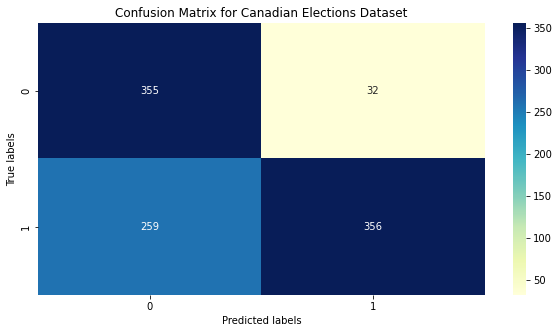

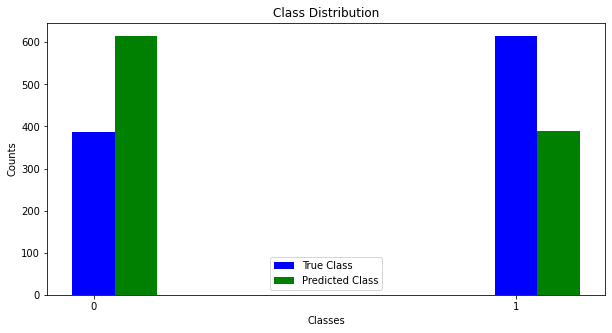

In [32]:
#canadian election dataset
visualize(y_can, y_preds)

## **<font color='orange'>4.a.c Results for Each Party</font>**

The already predicted results can be sepearated for each party. But, that would mean to extract the relevant indices. Instead, The below section analyzes the data for each party separately . The data is then fed to the trained model and the prediction for each party are calculated.

### **<font color='orange'>LPC Party: </font>**

It can be seen from the scores that the accuracy reduced when compared to the results with complete dataset. 

From the distribution we can see that the positive and negative labels are equally distributed in the dataset. For the predictions, the negative labels had higher frequency. The result is similar to what we had for the whole dataset. 


The accuracy score for the LPC Party is: 0.6857142857142857

The F1 score for each class is: [0.73567468 0.61246612]


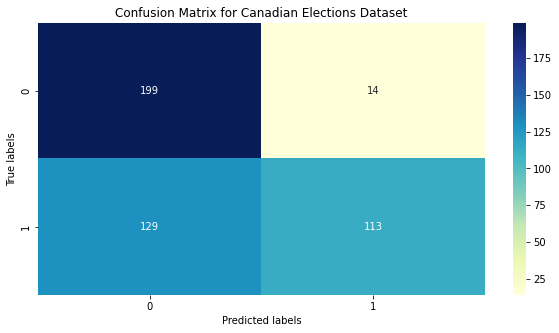

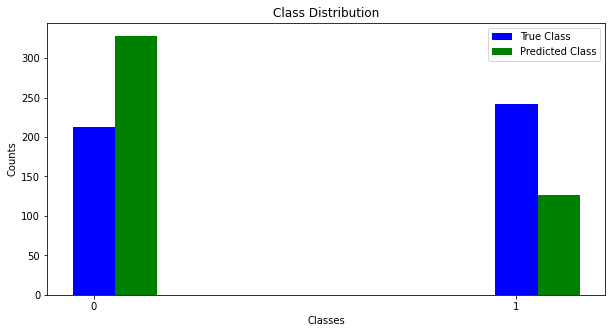

In [ ]:
#LPC
can_LPC = can_use_r[can_use_r['Max']=='LPC']
X_can_LPC = can_LPC
y_can_LPC = can_LPC['label']
X_can_bag_LPC = vectorizer_1.transform(X_can_LPC['text'].values)

y_preds_LPC = model_final.predict(X_can_bag_LPC)

accs_LPC = metrics.accuracy_score(y_can_LPC, y_preds_LPC)
  
print("The accuracy score for the LPC Party is: {}".format(accs_LPC))
visualize(y_can_LPC, y_preds_LPC)



### **<font color='orange'>CPC Party: </font>**

The second highest share in the dataset is that of the CPC party. in contrast to the sentiment of the LPC party, CPC party had a higher proportion of the positive labels in the true dataset.  

For the predictions, a similar trend is observed. The negative labels were predicted frequently. Thsi can mean that some of the positive labelled tweets had words which were negative. 

The accuracy observed is also higher than the overall dataset (0.725). 

The accuracy score for the CPC Party is: 0.7246963562753036

The F1 score for each class is: [0.73643411 0.71186441]


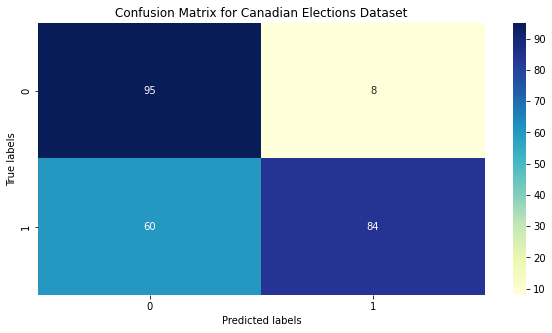

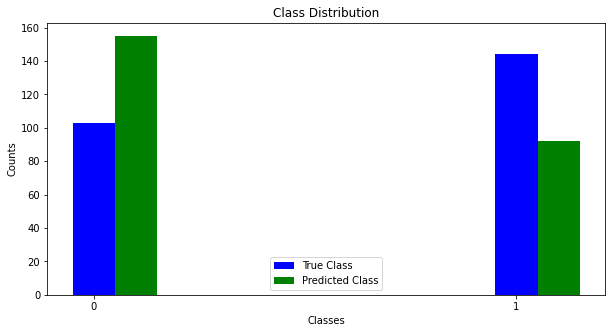

In [ ]:
#CPC
can_CPC = can_use_r[can_use_r['Max']=='CPC']
X_can_CPC = can_CPC
y_can_CPC = can_CPC['label']
X_can_bag_CPC = vectorizer_1.transform(X_can_CPC['text'].values)

y_preds_CPC = model_final.predict(X_can_bag_CPC)

accs_CPC = metrics.accuracy_score(y_can_CPC, y_preds_CPC)
  
print("The accuracy score for the CPC Party is: {}".format(accs_CPC))
visualize(y_can_CPC, y_preds_CPC)


### **<font color='orange'>NDP Party: </font>**

The NDP party had a comparatively lower share in the dataset than the above two parties. But what is quite opposite when compared to those in the distribution is that there are a higher number of positive tweets than the negative tweets. In terms of prediction, a similar trend is seen. The negative tweets predicted are more than the original negative tweets.


The accuracy score for the NDP Party is: 0.75

The F1 score for each class is: [0.47058824 0.83636364]


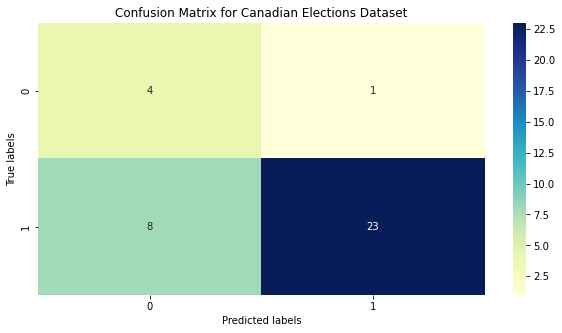

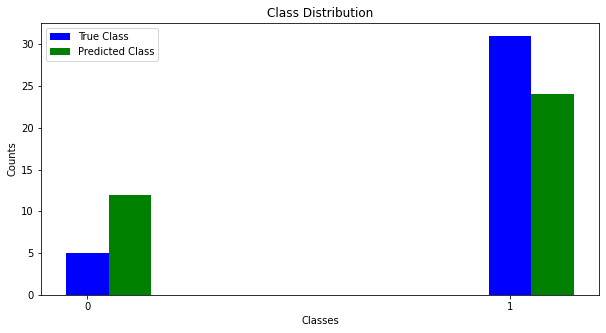

In [ ]:
#NDP
can_NDP = can_use_r[can_use_r['Max']=='NDP']
X_can_NDP = can_NDP
y_can_NDP = can_NDP['label']
X_can_bag_NDP = vectorizer_1.transform(X_can_NDP['text'].values)

y_preds_NDP = model_final.predict(X_can_bag_NDP)

accs_NDP = metrics.accuracy_score(y_can_NDP, y_preds_NDP)
  
print("The accuracy score for the NDP Party is: {}".format(accs_NDP))
visualize(y_can_NDP, y_preds_NDP)

### **<font color='orange'>PPC Party: </font>**

The PPC Party has a higher share of the positive tweet as well in the original dataset. However, the accuracy is very low. 


The accuracy score for the PPC Party is: 0.5689655172413793

The F1 score for each class is: [0.3902439  0.66666667]


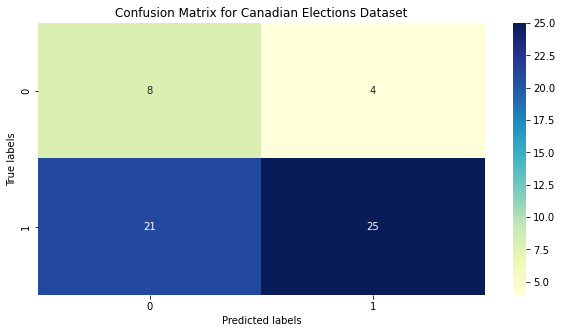

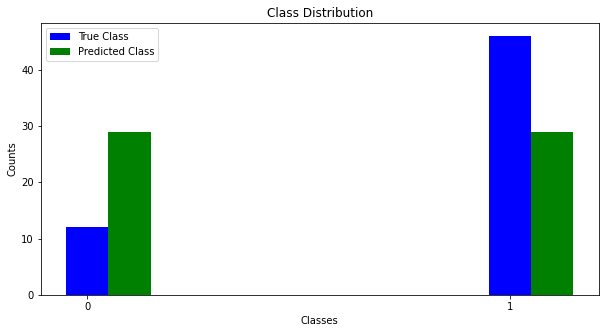

In [ ]:

#PPC
can_PPC = can_use_r[can_use_r['Max']=='PPC']
X_can_PPC = can_PPC
y_can_PPC = can_PPC['label']
X_can_bag_PPC = vectorizer_1.transform(X_can_PPC['text'].values)

y_preds_PPC = model_final.predict(X_can_bag_PPC)

accs_PPC = metrics.accuracy_score(y_can_PPC, y_preds_PPC)
  
print("The accuracy score for the PPC Party is: {}".format(accs_PPC))
visualize(y_can_PPC, y_preds_PPC)

### **<font color='orange'>Discussion</font>**

1. The prediction accuracy were lower for 'LPC' and 'PPC' when comapred to the other two parties. 

2. Although the accuracies were not optimal for all cases, the NLP techniques can definitely be used by parties in the election campiagn to take accurate steps, promotions and improvements to develop a better image of the party. The dataset used to train the model will be key in order to get accurate model performance. The canadian election dataset had some negative words in the tweets whcih were labeled as positive sentiment. This can be accurate but will lead to variances in the result as the dataset in the generic tweets had very different set of positive words.

3. The distribution of the negative and positive tweets for the LPC party is quite similar. This means that the sentiment is balanced with slight inclination towards positive sentiment. However, ratio of positive to the negative tweet is higher for the CPC party. A higher proportion of tweets among the CPC party tweets were positive. The tweets that referred NDP and LPC were mostly positive. This means that their public image was positive but the popularity was low in comparison to the other two parties.

4. The first idea that can be used to improve the accuracy of the model is to eliminate words that don't add additional information about the concerned topic such as 'canadian', 'canada', 'election' etc. This will further tune down the total features and focus more on the other important key words. In addition to that, some more stopwords can be added for both the datasets and observe how the accuracies vary.


## **<font color='orange'>4.b Negative Sentiments</font>**

In this section the focus is on the negative labeled data in the canadian election dataset. The dataset is then splitted into 70% as training set and 30% as testing set. Some of the rarely occuring reasons such as 'healthcare and marijuana', 'segregation', and 'women reproductive right and racism' were combined with 'Others'. In the hyperparameters tuning, a 'cv' of 10 was used. Hence, the reasons which had a count of less than 10 were combined with others.

In [35]:
#delete the particular dataframe just in case if the code is re-ran 
try:
  del can_neg
except:
  pass

#Select negative sentiment data
can_neg = can_use_r[can_use_r['sentiment']=='negative']

#Replacing some points with lower frequency into others
can_neg.loc[can_neg['negative_reason']=='healthcare and marijuana'] = 'others'
can_neg.loc[can_neg['negative_reason']=='segregation'] = 'others'
can_neg.loc[can_neg['negative_reason']=='women reproductive right and racism'] = 'others'

#Create one-hot encoding --> (not required)
dummies_i = pd.get_dummies(can_neg['negative_reason'], prefix='y')
#can_neg = pd.concat([can_neg, dummies_i], axis=1)

#Splitting X and y for model input
X_neg = can_neg
y_neg = can_neg['negative_reason']
X_neg_tr, X_neg_ts, y_neg_tr, y_neg_ts = train_test_split(X_neg, y_neg, test_size=0.30, stratify=y_neg, random_state=100)

#Use countVectorizer()
vectorizer_3 = CountVectorizer()
vectorizer_3.fit(X_neg_tr['text'].values)

#Transform the test and the train data using the fitted vectorizer
X_neg_tr_bag = vectorizer_3.transform(X_neg_tr['text'].values)
X_neg_ts_bag = vectorizer_3.transform(X_neg_ts['text'].values)

print("Shape after count vectorizations")
print("Train Set X, y: {},{}".format(X_neg_tr_bag.shape, y_neg_tr.shape))
print("Test Set X, y: {}, {}\n".format(X_neg_ts_bag.shape, y_neg_ts.shape))

Shape after count vectorizations
Train Set X, y: (270, 1753),(270,)
Test Set X, y: (117, 1753), (117,)



/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

The below cell just visualizes the distribution of the different negative reasons.

In [36]:
print(np.sum(dummies_i, axis=0))

y_calling election early     73
y_climate problem            15
y_covid                      25
y_economy                    20
y_gun control                16
y_others                    163
y_scandal                    14
y_tell lies                  61
dtype: int64


### **<font color='orange'>Hyperparameter Tuning</font>**

The below cell implements a function for grid search cv. The function also plots two graphs. The first one indicates the mean accuracy score for each hyperparameter value. In addition to that, the total error was also calculated for each hyperparameter which constitutes of the bias and the variance. 

The parameter for which the total error is less was selected as the best parameter.

In [37]:
def model_implement_cv(model, X, y, params, scoring):
  #kfold (10 splits)
  kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
  clf = GridSearchCV(model, param_grid, scoring=scoring, cv=kfold, return_train_score=True)
  clf.fit(X, y)

  results = pd.DataFrame.from_dict(clf.cv_results_)
  results = results.sort_values(['param_{}'.format(list(params.keys())[0])])
  print("The parameter is: {}".format(['param_{}'.format(list(params.keys())[0])]))
  
  train_score_mean = results['mean_train_score']
  train_score_std = results['std_train_score']

  cv_score_mean = results['mean_test_score']
  cv_score_std = results['std_test_score']

  K = results['param_{}'.format(list(params.keys())[0])]
  plt.plot(K, train_score_mean, label='Train Score')
  plt.plot(K, cv_score_mean, label='CV Score')

  plt.scatter(K, train_score_mean, label='Train Score points')
  plt.scatter(K, cv_score_mean, label='CV Score points')

  plt.xscale('log')
  plt.legend()
  plt.xlabel("K: hyperparameter")
  plt.ylabel("Score")

  plt.title("Hyper parameter Vs Accuracy Score plot")
  plt.grid()
  plt.show()

  error_train = np.add(np.power((1-train_score_mean),2),np.power(train_score_std,2))
  error_test = np.add(np.power((1-cv_score_mean),2),np.power(cv_score_std,2))

  plt.plot(K, error_train, label='Train Total Error')
  plt.plot(K, error_test, label='CV Total Error')

  plt.scatter(K, error_train, label='Train Error points')
  plt.scatter(K, error_test, label='CV Error points')

  plt.xscale('log')
  plt.legend()
  plt.xlabel("K: hyperparameter")
  plt.ylabel("Error")

  plt.title("Hyper parameter Vs Total Error (Bias^2 + Variance)")
  plt.grid()
  plt.show()

  print("\nThe best parameter value is: {}".format(clf.best_params_))
  print("\nThe best score is: {}".format(clf.best_score_))

  return clf.best_score_, clf.best_params_, clf.best_estimator_


### **<font color='orange'>Selected Model: Logisitic Regression</font>**

For this task, Logistic Regression was preferred just to have a comparison with the results from previous section. From the plots presented below it can be seen that the total error is lowest for the C value of 10,000. Although the performance of the model on the test set is extremely poor in comparison to that of the training set. 


Results when Count Vectorizer input is selected:

The parameter is: ['param_C']


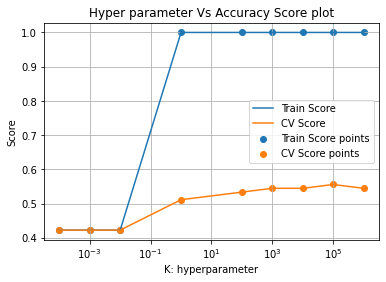

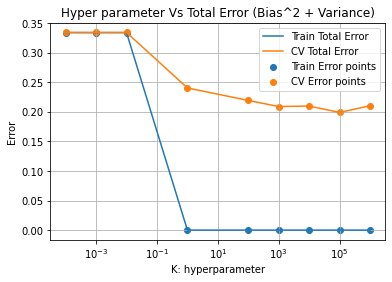


The best parameter value is: {'C': 100000}

The best score is: 0.5555555555555556


In [ ]:
modelneg = LogisticRegression(max_iter=10000, multi_class='ovr')
C = [0.0001, 0.001, 0.01, 1, 100, 1000, 10000, 100000, 1000000]
param_grid = dict(C=C)

print("\nResults when Count Vectorizer input is selected:\n")
best_score, best_param, best_est = model_implement_cv(modelneg, X_neg_tr_bag, y_neg_tr, param_grid, 'accuracy')


The selected hyperparameters are then set for the final model, and the model performance is checked for the complete training set. It can be seen that the model performs quite well. This means that there is overfitting in this case. The dataset is quite small, and this further makes it difficult to further improve the test results if the same dataset is considered. 

From the hyperparameter tuning section, we can see that the accuracy of the cross validation set was very low. But when the complete training dataset is considered below, the accuracy is 100%. This highlights the problem of low datapoints.

The accuracy score for the Train negative tweets: 1.0

The F1 score for each class is: [1. 1. 1. 1. 1. 1. 1. 1.]


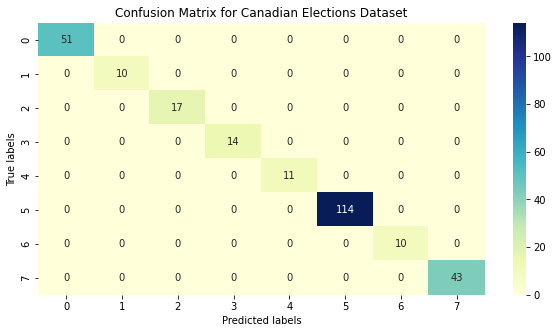

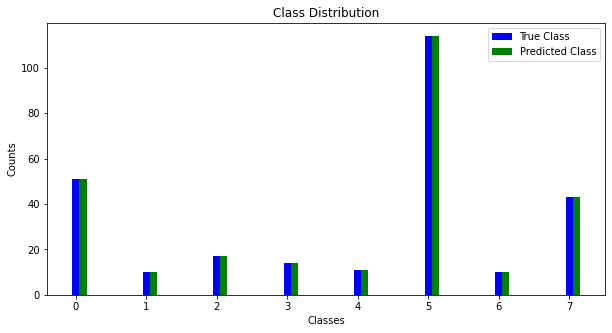

In [ ]:
modelneg = LogisticRegression(max_iter=10000, multi_class='ovr', C=100)
modelneg.fit(X_neg_tr_bag,y_neg_tr)

y_preds_neg_tr = modelneg.predict(X_neg_tr_bag)
accs_neg_tr = metrics.accuracy_score(y_neg_tr, y_preds_neg_tr)
  
print("The accuracy score for the Train negative tweets: {}".format(accs_neg_tr))
visualize(y_neg_tr, y_preds_neg_tr, n=8)

Having understood the training performance, the trained model is used on the test dataset. It can be observed that the model performance drops drastically. The F1 score is also included to demonstrate the score of each class.

The accuracy score for the Train negative tweets: 0.48717948717948717

The F1 score for each class is: [0.58181818 0.         0.18181818 0.         0.6        0.63716814
 0.         0.07142857]


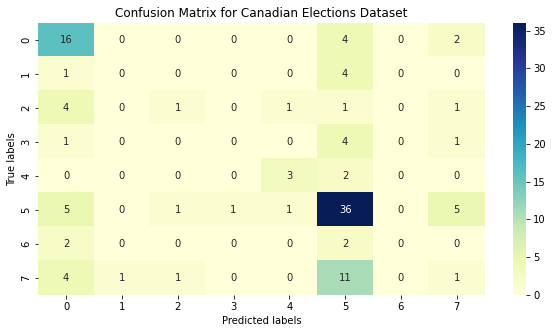

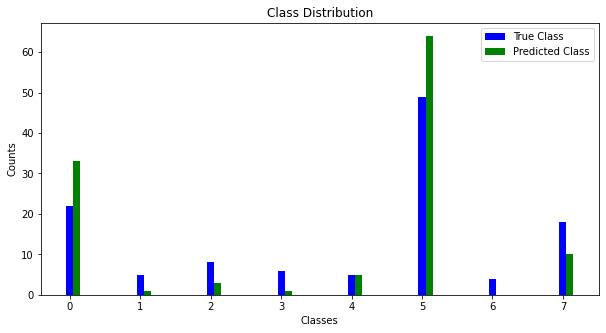

In [ ]:
y_preds_neg_ts = modelneg.predict(X_neg_ts_bag)
accs_neg_ts = metrics.accuracy_score(y_neg_ts, y_preds_neg_ts)
  
print("The accuracy score for the Train negative tweets: {}".format(accs_neg_ts))
visualize(y_neg_ts, y_preds_neg_ts, n=8)

## **<font color='orange'>4.b.a Reason for Poor Performance</font>**

One of the reasons for a poor performance of the model is the severe class imbalance in the dataset. It can be observed that the classes with the highest representation: Class 0 and Class 5 have over predictions. The model is also not able to generalize well to the new data because of very few datapoints. 

## **<font color='orange'>4.b.b Suggestion for improvement of model performance</font>**

One method to improve the performance of the model is to generate synthetic datapoints which can improve model generalization. 

Some methods to develop synthetic datapoints are:
1. OverSampling 
2. UnderSampling
3. SMOTE
4. ADASYN
5. SMOTE + Tomek
6. SMOTE + Enn 



```
#Examples:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
```
In addition to this, model features can be studied further and some of the irrelevant words can be eliminated. This is also discussed in part 4.c


## **<font color='orange'>4.c Top-50 most frequent words</font>**

There can be multiple ways of finding this set of words. In the section below, the positive and negative tweets are separated. CountVectorizer is applied on both of these separately. The sorted list is presented with top 50 elements for both of the dataset.

It can be observed that some of the most common words like 'election', 'canada', 'canadian' are part of both of these tweets. These words can be included in the stopwords list and eliminated before running the models. 

The top 50 words in the positive sentiment dataset are positive in nature.

The top 50 words in the negative sentiment contain a lot of irrelevant words like would, want, wants etc. To further improve the performance, lemmatization can be used which eliminates words with same root word. 

In [41]:
can_pos = can_use_r[can_use_r['sentiment']=='positive']
Vp = CountVectorizer()
Xp = Vp.fit_transform(can_pos['text'].values)

sum_wordsp = Xp.sum(axis=0) 
words_freqp = [(word, sum_wordsp[0, idx]) for word, idx in Vp.vocabulary_.items()]
words_freqp = sorted(words_freqp, key = lambda x: x[1], reverse=True)
top_features_p = words_freqp[:50]

print('Top 50 frequent words are: \n{}'.format(top_features_p))

Top 50 frequent words are: 
[('election', 395), ('vote', 184), ('canadian', 173), ('trudeau', 171), ('canadians', 138), ('canada', 123), ('otoole', 121), ('good', 74), ('win', 62), ('party', 60), ('federal', 59), ('get', 59), ('like', 54), ('day', 45), ('best', 44), ('freedom', 42), ('us', 40), ('would', 38), ('better', 38), ('voting', 36), ('people', 36), ('hope', 36), ('support', 35), ('great', 35), ('justin', 35), ('want', 35), ('liberal', 35), ('need', 34), ('ppc', 33), ('right', 33), ('time', 32), ('love', 31), ('voted', 30), ('conservatives', 30), ('ndp', 30), ('dont', 30), ('think', 30), ('one', 28), ('go', 28), ('make', 27), ('please', 27), ('parties', 26), ('let', 25), ('im', 25), ('going', 24), ('conservative', 24), ('pandemic', 23), ('government', 23), ('liberals', 23), ('cpc', 23)]


In [42]:
can_neg = can_use_r[can_use_r['sentiment']=='negative']
Vn = CountVectorizer()
Xn = Vn.fit_transform(can_neg['text'].values)



sum_wordsn = Xn.sum(axis=0) 
words_freqn = [(word, sum_wordsn[0, idx]) for word, idx in Vn.vocabulary_.items()]
words_freqn =sorted(words_freqn, key = lambda x: x[1], reverse=True)
top_features_n = words_freqn[:50]

print('Top 50 frequent words are: \n{}'.format(top_features_n))

Top 50 frequent words are: 
[('election', 260), ('trudeau', 146), ('canadians', 145), ('otoole', 99), ('canada', 69), ('canadian', 61), ('pandemic', 48), ('like', 43), ('vote', 41), ('called', 29), ('party', 27), ('pm', 26), ('years', 24), ('dont', 24), ('one', 23), ('people', 23), ('never', 23), ('get', 23), ('justin', 23), ('gun', 22), ('call', 22), ('conservatives', 21), ('would', 21), ('calling', 21), ('us', 21), ('care', 20), ('country', 19), ('many', 19), ('erin', 19), ('good', 19), ('leader', 18), ('going', 18), ('think', 17), ('unnecessary', 17), ('say', 17), ('know', 17), ('bad', 17), ('government', 16), ('way', 16), ('liberals', 16), ('conservative', 16), ('liberal', 16), ('covid', 15), ('see', 15), ('wants', 15), ('want', 15), ('federal', 15), ('million', 15), ('time', 14), ('toole', 14)]


## **<font color=#00008B> Conclusion</font>** 

This jupyter notebook focused on the implementation of the NLP techniques. The methods for parsing and cleaning the data was studied. Interesting concepts were learnt for developing indepth insights using the exploratory data analysis. Several different models were explored for text classification and hyperparameter tuning was performed. Overall, this assignement combined several concepts to understand the implementation of Sentiment Analysis, develop discussions of the observed results, and even identify methods to improve the implementation.